## Modelling

### Includes:
- K-means clustering
- Random Forest Classification
- Multilayer Perceptron Classification
- Support Vector Classification

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import sklearn
import shapely.wkt
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import mplleaflet
from scipy.spatial.distance import pdist, squareform, euclidean, directed_hausdorff
from haversine import haversine
import collections
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler


%matplotlib inline

In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters
mtl_region = gpd.read_file("../shapes/mtl_all_regions.json")
mtl_dissem = gpd.read_file("../shapes/mtl_dissem.geojson")
mtl_greater = gpd.read_file("../shapes/greater_montreal.geojson")
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]

In [3]:
mtl_greater['geometry'] = mtl_greater.buffer(0.01)
mtl_greater = mtl_greater.dissolve(by="CMANAME")

In [4]:
# outlier removal
gdf = gdf.loc[gdf.distance_m >= 50]
gdf = gdf.loc[gdf.seconds >= 60]
gdf = gdf.loc[gdf.distance_m <= 100000]
gdf = gdf.loc[gdf.seconds <= 10800]
gdf = gdf.dropna(subset=['mode'])
gdf = gdf.reset_index(drop=True)

In [5]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [6]:
gdf['log_dur'] = np.log(gdf.seconds+1)
gdf['log_dist'] = np.log(gdf.distance_m+1)

In [7]:
gdf.purpose.value_counts()

returning_home      26819
work                18950
leisure              9167
shops                8363
cafe                 3115
education            2769
pick_up_a_person     1574
other                1203
health               1044
not_available          25
Name: purpose, dtype: int64

## new purpose classifications
NOTE: This is unused, but was going to group the purpose classes based on similarity in space and time

In [409]:
new_classifications = {"1":["shops","leisure","cafe","returning_home"],"2":["education"],\
                       "3":["health"],"4":["pick_up_a_person"],"5":["work"]}

In [410]:
def new_pur_labels(row, purpose_label_dict=new_classifications):
    for key, val in purpose_label_dict.items():
        if row.purpose in val:
            return key

    return None

In [411]:
gdf['purpose_labels'] = gdf.apply(new_pur_labels, axis=1)

In [412]:
gdf.purpose_labels.value_counts()

1    47464
5    18950
2     2769
4     1574
3     1044
Name: purpose_labels, dtype: int64

In [413]:
gdf = gdf.dropna(subset=["purpose_labels"])

In [414]:
## get all the purposes and modes above 1000 trips
above1000_purpose = gdf.groupby(['purpose']).count()['id_trip'][gdf.groupby(['purpose']).count()['id_trip'] > 1000].index
above1000_mode = gdf.groupby(['mode']).count()['id_trip'][gdf.groupby(['mode']).count()['id_trip'] > 1000].index
ordered_days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [415]:
mtl_land_use = gpd.read_file('../data/mtl_land_use.json')

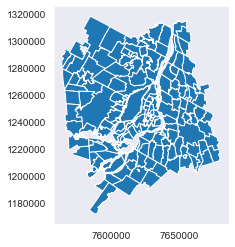

In [146]:
mtl_region.plot()
# plt.savefig("a_test.png")

## Join data to land use

In [8]:
# convert the point columns back into a Point class
gdf['start_wgs'] = gdf['start_wgs'].apply(shapely.wkt.loads)
gdf['start_can'] = gdf['start_can'].apply(shapely.wkt.loads)
gdf['end_wgs'] = gdf['end_wgs'].apply(shapely.wkt.loads)
gdf['end_can'] = gdf['end_can'].apply(shapely.wkt.loads)

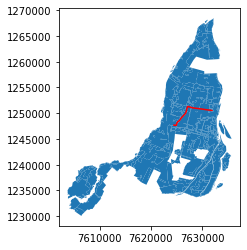

In [17]:
fig, ax = plt.subplots(1)
mtl_land_use.plot(ax=ax)
gdf.loc[0:0].plot(ax=ax, color='r')


In [9]:
%%time
## 25 mins
def intersect_landuse(row):
    try:
        the_cat = mtl_land_use.iloc[np.where(mtl_land_use.intersects(shapely.geometry.Point(row.start_can)))[0]].categorie
        return the_cat.values[0]
    except:
        return "0"
    
def intersect_landuse_end(row):
    try:
        the_cat = mtl_land_use.iloc[np.where(mtl_land_use.intersects(shapely.geometry.Point(row.end_can)))[0]].categorie
        return the_cat.values[0]
    except:
        return "0"
gdf['land_use_start'] = gdf.apply(intersect_landuse, axis=1)
gdf['land_use_end'] = gdf.apply(intersect_landuse_end, axis=1)

CPU times: user 19.7 s, sys: 209 ms, total: 19.9 s
Wall time: 20.6 s


In [10]:
gdf.land_use_start.value_counts()

0    73029
Name: land_use_start, dtype: int64

In [1]:
sns.set_style("darkgrid")
col_order = ['0','conservation','diversified activities','employment','infrastructure','institution',\
             'mixed','park','religious','residential']

grouped_purpose_all = gdf.groupby(['land_use_start']).count()['id_trip']
grouped_purpose_other = gdf.groupby(['land_use_end']).count()['id_trip']

fig, ax = plt.subplots(1, figsize=(10,6))
ind = np.arange(len(grouped_purpose_all))
height = .3

ax.barh(y=ind, width=grouped_purpose_all, height=height, alpha=.75)
ax.barh(y=ind+height, width=grouped_purpose_other,height=height, color='orange', alpha=.75)
ax.set_yticks(ind + height / 2)
plt.xticks(size=16)
plt.yticks(size=20)
ax.set_yticklabels([col.title() if col != '0' else 'None' for col in col_order], size=20)
ax.set_xlabel("Count of Trips", size=20)

ax.legend(['Origin','Destination'], fontsize=18);
ax.set_title("Land use categories of origin and destination points", size=24)
# ax.figure.savefig("figures/landuse_cats.png", bbox_inches='tight')

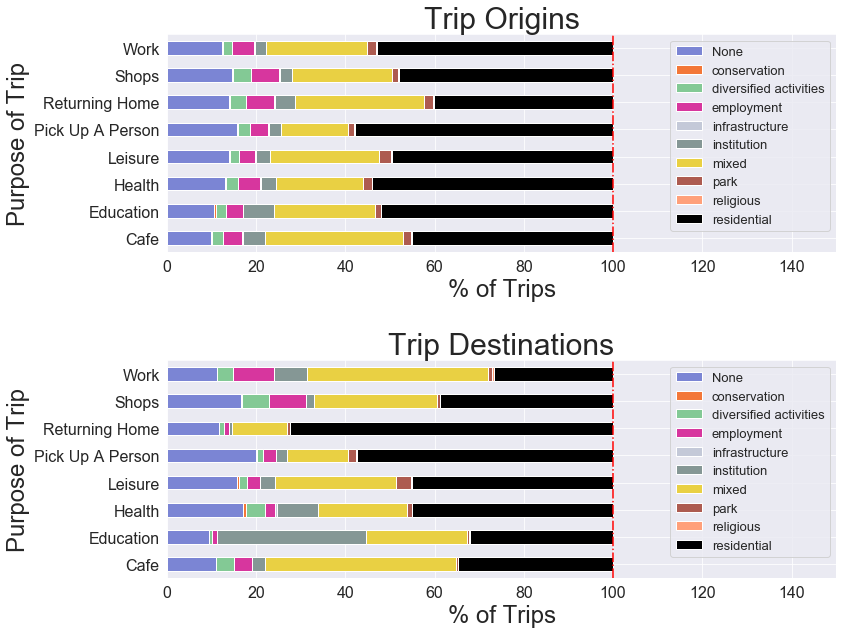

In [575]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
purp_gdf = gdf.groupby(['purpose', "land_use_start"]).count().reset_index()
purp_gdf.land_use_start = purp_gdf.land_use_start.apply(lambda lu: 'None' if lu == '0' else lu )
gpd.pd.DataFrame([purp_gdf.loc[purp_gdf.purpose == pur].sort_values(by='id_trip', ascending=False)[['land_use_start', 'id_trip']][:].pivot(columns="land_use_start", values='id_trip').sum(axis=0)/purp_gdf.loc[purp_gdf.purpose == pur].sort_values(by='id_trip', ascending=False)[['land_use_start', 'id_trip']][:].pivot(columns="land_use_start", values='id_trip').sum(axis=0).sum()*100 for pur in purp_gdf.purpose.unique()[:]]).plot(kind='barh',stacked=True, ax=ax, color=colorblind_pallette)

purp_gdf2 = gdf.groupby(['purpose', "land_use_end"]).count().reset_index()
purp_gdf2.land_use_end = purp_gdf2.land_use_end.apply(lambda lu: 'None' if lu == '0' else lu )
purp_gdf2.land_use_start = purp_gdf.land_use_start.apply(lambda lu: 'None' if lu == '0' else lu )
gpd.pd.DataFrame([purp_gdf2.loc[purp_gdf2.purpose == pur].sort_values(by='id_trip', ascending=False)[['land_use_end', 'id_trip']][:].pivot(columns="land_use_end", values='id_trip').sum(axis=0)/purp_gdf2.loc[purp_gdf2.purpose == pur].sort_values(by='id_trip', ascending=False)[['land_use_end', 'id_trip']][:].pivot(columns="land_use_end", values='id_trip').sum(axis=0).sum()*100 for pur in purp_gdf.purpose.unique()[:]]).plot(kind='barh',stacked=True, ax=ax2, color=colorblind_pallette)

ax.set_yticklabels([pur.replace("_", " ").title() for pur in purp_gdf.purpose.unique()[:]], size=16)
ax2.set_yticklabels([pur.replace("_", " ").title() for pur in purp_gdf.purpose.unique()[:]], size=16)
ax.set_xticklabels(np.arange(0,150,20),size=16)
ax2.set_xticklabels(np.arange(0,150,20),size=16)
ax.set_xlabel("% of Trips", size=24)
ax2.set_xlabel("% of Trips", size=24)
ax.set_ylabel("Purpose of Trip", size=24)
ax2.set_ylabel("Purpose of Trip", size=24)
ax.set_title("Trip Origins", size=30)
ax2.set_title("Trip Destinations", size=30)

ax.set_xlim(0,150)
ax2.set_xlim(0,150)

ax.legend(loc=1, fontsize=13)
ax2.legend(loc=1, fontsize=13)
ax.axvline(100,0,10, color='r', linestyle='-.')
ax2.axvline(100,0,10, color='r', linestyle='-.')
# plt.savefig("figures/purpose_vs_sperclanuse.png", bbox_inches='tight')

In [12]:
land_use_start_unique = gdf.land_use_start.unique().copy()
land_use_end_unique = gdf.land_use_end.unique().copy()

## K-means Clustering before classification

In [13]:
gdf['startx'] = gdf.start_can.apply(lambda row: row.x)
gdf['starty'] = gdf.start_can.apply(lambda row: row.y)
gdf['endx'] = gdf.end_can.apply(lambda row: row.x)
gdf['endy'] = gdf.end_can.apply(lambda row: row.y)

In [14]:
# Calculate DISTANCE MATRIX
coords_st = [[x,y] for x, y in zip(gdf['startx'], gdf['starty'])]
coords_en = [[x,y] for x, y in zip(gdf['endx'], gdf['endy'])]

In [15]:
# get a list of all end-points for clustering algorithm
overall_coords = coords_st
overall_coords.extend(coords_en)

In [16]:
len(overall_coords)

146058

In [158]:
# %%time
# Run the Kmeans algorithm and get the index of data points clusters
# sse = []
# list_k = list(range(1, 25))

# for k in list_k:
#     km = KMeans(n_clusters=k)
#     km.fit(overall_coords)
#     sse.append(km.inertia_)

In [21]:
# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(range(1,len(sse)+1), sse, '-o')
# plt.axvline(6,0,1, linestyle='--', color='k')
# plt.xlabel(r'Number of clusters *k*', size=18)
# plt.ylabel('Sum of squared distance', size=18);
# plt.savefig('figures/elbowplot_kmeans.png', bbox_inches='tight')

In [31]:
# pd.DataFrame(sse).to_csv("analysis_results/kmean_sse.csv", index=False)
sse = pd.read_csv("analysis_results/kmean_sse.csv")
sse['num_clusters'] = np.arange(2, 51)

In [33]:
np.arange(2,len(sse)+2)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [17]:
%%time
kmeans = KMeans(n_clusters=12, random_state=0).fit(overall_coords)
kmeans.labels_

CPU times: user 7.7 s, sys: 1.13 s, total: 8.84 s
Wall time: 8.04 s


array([ 8,  9,  1, ..., 11,  1,  6], dtype=int32)

In [18]:
gdf['startclust'] = kmeans.labels_[:int(len(gdf))]
gdf['endclust'] = kmeans.labels_[int(len(gdf)):]

In [19]:
print(gdf.startclust.value_counts())
print(gdf.endclust.value_counts())

0     20012
1     18061
11    10545
6     10001
8      6875
5      2083
2      1974
3      1644
9       838
10      406
7       397
4       193
Name: startclust, dtype: int64
0     20697
1     17907
11    10005
6      9978
8      6834
2      2151
5      2088
3      1702
9       820
7       360
10      356
4       131
Name: endclust, dtype: int64


In [37]:
# %%time
# sihouette_scores = []
# # The silhouette_score gives the average value for all the samples.
# # This gives a perspective into the density and separation of the formed clusters
# for i in range(2,30):
#     print(i)
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(overall_coords)
#     sihouette_scores.append(silhouette_score(overall_coords, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
CPU times: user 1h 13min 57s, sys: 15min 39s, total: 1h 29min 37s
Wall time: 1h 21min 24s


In [480]:
# silh_scores = pd.DataFrame([np.arange(2,20), sihouette_scores]).T
# silh_scores.columns = ['clusters','silhscore']
# silh_scores.to_csv("analysis_results/silhscores.csv", index=False)

In [481]:
silh_scores = pd.read_csv("analysis_results/silhscores.csv")

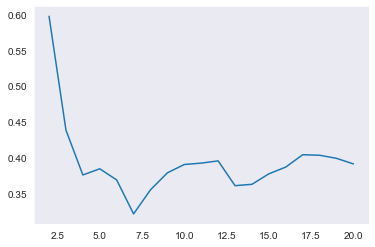

In [482]:
# The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
plt.plot(silh_scores.clusters, silh_scores.silhscore)

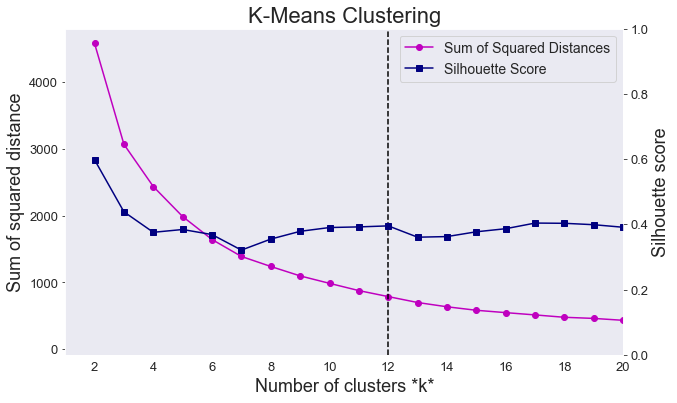

<Figure size 432x432 with 0 Axes>

In [498]:
# Plot sse against k
sns.set_style("dark")
fig, ax = plt.subplots(1, figsize=(10,6))
plt.figure(figsize=(6, 6))
ln1 = ax.plot(np.arange(2,len(sse)+2), sse.sse_clusters, '-o', color='m', label='Sum of Squared Distances')
ax.axvline(12,0,1, linestyle='--', color='k')
ax.set_xlabel(r'Number of clusters *k*', size=18)
ax.set_ylabel('Sum of squared distance', size=18);
ax2 = ax.twinx()
ln2 = ax2.plot(silh_scores.clusters, silh_scores.silhscore, color='navy', marker='s', label='Silhouette Score')
ax2.set_ylabel("Silhouette score",size=18)
ax.set_yticklabels(labels=[1, 0, 1000, 2000,3000,4000], size=13)
ax.set_xticks(np.arange(0,51, 2))
ax.set_xticklabels(labels=np.arange(0,51, 2), size=13)
ax2.set_ylim(0,1)
ax.set_xlim(1, 20)
ax2.set_yticklabels(labels=[round(i, 2) for i in np.arange(0,1.1, .2)], size=13)
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=14)
ax.set_title("K-Means Clustering", size=22)
# ax.figure.savefig('figures/elbowplot_kmeans_sum_silh.png', bbox_inches='tight')
plt.show()


In [433]:
colorblind_pallette = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k","cyan",'pink']
colorblind_pallette = cm.ListedColormap(colorblind_pallette)

In [434]:
import matplotlib.patches as mpatches

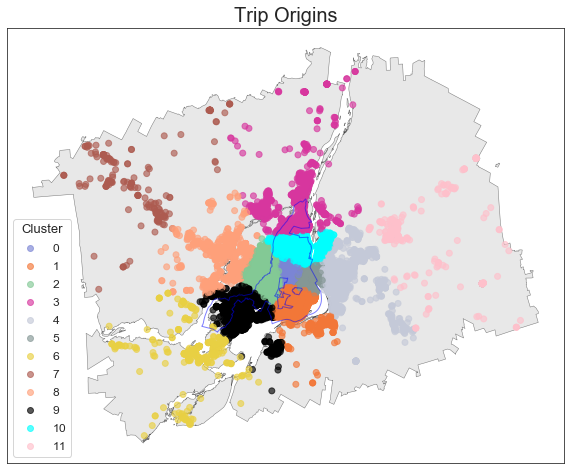

In [439]:
sns.set_style("white")
fig, ax = plt.subplots(1, figsize=(14, 8))
mtl_dissem.dissolve(by='PRNAME').plot(ax=ax, color='lightgrey', alpha=.5, linewidth=0.5, edgecolor='k')

scatter = ax.scatter(gdf.startx, gdf.starty, c=gdf.startclust, cmap=colorblind_pallette, alpha=.65)
city_of_montreal.dissolve(by="TYPE").plot(ax=ax, color=None, facecolor='none', edgecolor='blue', linewidth=1, alpha=.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster", fontsize=12 )

plt.xticks([]); plt.yticks([]);
ax.set_title("Trip Origins", size=20)
legend1.set_title('Cluster',prop={'size':13})
# ax.figure.savefig("figures/kmeans_cluster_start.png", bbox_inches='tight')

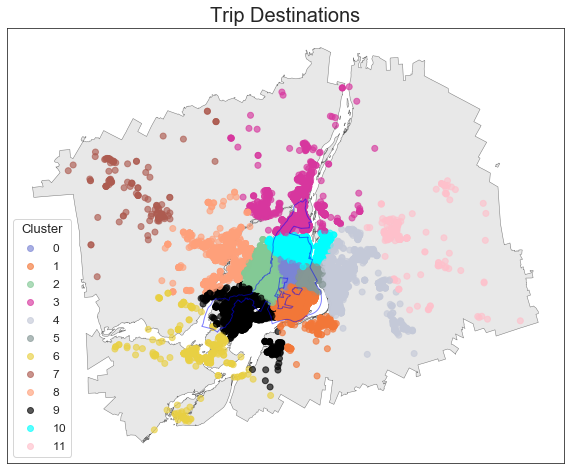

In [438]:
fig, ax = plt.subplots(1, figsize=(14, 8))
mtl_dissem.dissolve(by='PRNAME').plot(ax=ax, color='lightgrey', alpha=.5, linewidth=0.5, edgecolor='k')

scatter = ax.scatter(gdf.endx, gdf.endy, c=gdf.endclust, cmap=colorblind_pallette, alpha=.65)
city_of_montreal.dissolve(by="TYPE").plot(ax=ax, color=None, facecolor='none', edgecolor='blue', linewidth=1, alpha=.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster", fontsize=12 )

plt.xticks([]); plt.yticks([]);
ax.set_title("Trip Destinations", size=20)
legend1.set_title('Cluster',prop={'size':13})
# ax.figure.savefig("figures/kmeans_cluster_end.png", bbox_inches='tight')

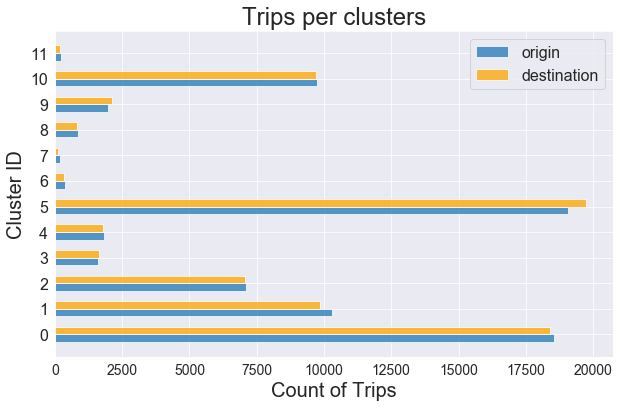

In [496]:
col_order = ['0','1','2','3','4','5','6','7','8','9','10','11']

sns.set_style("darkgrid")
grouped_cluster_origin = gdf.groupby('startclust').count()['mode']
grouped_cluster_destination = gdf.groupby('endclust').count()['mode']

fig, ax = plt.subplots(1, figsize=(10,6))
ind = np.arange(len(grouped_cluster_origin))
height = .3

ax.barh(y=ind, width=grouped_cluster_origin, height=height, alpha=.75)
ax.barh(y=ind+height, width=grouped_cluster_destination,height=height, color='orange', alpha=.75)
ax.set_yticks(ind + height / 2)
ax.set_yticklabels(col_order, size=16)
ax.set_ylabel("Cluster ID", size=20)
plt.xticks(size=14)
ax.set_xlabel("Count of Trips",size=20)
ax.set_title("Trips per clusters", size=24)
ax.legend(['origin', 'destination'], fontsize=16);
# ax.figure.savefig("figures/trips_per_cluster.png", bbox_inches='tight')

In [ ]:
# pd.DataFrame(sse, columns=['sse_clusters']).to_csv("analysis_results/kmean_sse.csv", index=False)

## Subset by all, rush and city

In [20]:
new_column_labels = {"temporal_c":"Temporal Cluster Label","temperatur":"Temperature",
                     "distance_m":'Distance', "seconds":'Duration',\
                     "log_dist":'log(Distance)', "log_dur":'log(Duration)',\
                     "magnitude":'Directional magnitude', "precip":"Precipitation","carddir_f":'Direction',\
                     "mode_f":'Travel Mode', "endclust":'End Cluster Label',\
                     "startclust":'Start Cluster Label', "weekday":'Weekday?',\
                     "thrurush":'Through Rush Hour', "endrush":'End in Rush Hour',\
                     "startrush":'Start in Rush Hour', "end_downto":'End in City', "start_down":'Start in City',\
                    "land_use_start_f":"Starting Land Use", "land_use_end_f":"Ending Land Use",\
                     "purpose_labels":"Trip Purpose Class",\
                    "purpose_f":"Trip Purpose"}




In [104]:
purp_gdf = gdf.loc[(gdf.purpose != "not_available")&(gdf.purpose != "other")].reset_index(drop=True).copy()

purp_city = purp_gdf.loc[(purp_gdf.start_down == 1)|(purp_gdf.end_downto == 1)]
purp_noncity = purp_gdf.loc[(purp_gdf.start_down != 1)&(purp_gdf.end_downto != 1)]

purp_rush = purp_gdf.loc[(purp_gdf.startrush == 1)|(purp_gdf.endrush == 1)|(purp_gdf.thrurush == 1)]
purp_nonrush = purp_gdf.loc[(purp_gdf.startrush != 1)&(purp_gdf.endrush != 1)&(purp_gdf.thrurush != 1)]

In [ ]:
### TODO:
# make sure you have a deepcopied list for all purposes before factoristion

# Classification
Below is functions to carry out the classifiers 

In [106]:
from sklearn.model_selection import cross_val_score

# create common factors across the datasets (these need to be copied)
mode_factors = {}
for i, md in enumerate(pd.factorize(gdf['mode'])[1]):
    mode_factors[md] = i
    
land_use_factors = {}
for i, md in enumerate(pd.factorize(gdf['land_use_start'])[1]):
    land_use_factors[md] = i
    
purpose_factors = {}
for i, pr in enumerate(pd.factorize(gdf['purpose'])[1]):
    purpose_factors[pr] = i
    
carddir_factors = {}
for i, md in enumerate(pd.factorize(gdf['carddir'])[1]):
    carddir_factors[md] = i
    
def factorisation(row, land_use=False, mode=False,purpose=False, carddir=False):
    """function to map dictionaries to the data"""
    if land_use:
        return land_use_factors[row]
    elif purpose:
        return purpose_factors[row]
    elif mode:
        return mode_factors[row]
    elif carddir:
        return carddir_factors[row]
    
def model_setup(data, norm=False, oversample=False):
    data['land_use_start_f'] = data['land_use_start'].apply(factorisation, land_use=True)
    data['land_use_end_f'] = data['land_use_end'].apply(factorisation, land_use=True)
    data['purpose_f'] = data['purpose'].apply(factorisation, purpose=True)
    data['mode_f'] = data['mode'].apply(factorisation, mode=True)
    data['carddir_f'] = data['carddir'].apply(factorisation, carddir=True)
    
    X = data[['id_trip',"mode_f","seconds","distance_m","magnitude","carddir_f","start_down",\
          "end_downto","weekday", "temporal_c","precip","temperatur",\
        "startrush","endrush","thrurush","startclust","endclust","land_use_start_f","land_use_end_f"]]
    y = data[["purpose_f"]] # purpose_labels
    X.weekday = X.weekday.astype(int)
#     X = np.nan_to_num(X)
    feature_list = list(X.columns)
    if oversample:
        X, y = ros.fit_resample(X, y)
    if norm:
        X = normalise(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test, feature_list
    
def normalise(X):
    X = X / np.amax(X, axis=0)
    return X

def subset_to_imp_features(data, above_005):
    above_005.append("id_trip")
    data = data[data.columns[[col in above_005 for col in data.columns]]]
    return data
    

def run_rf(data, X_train=None, X_test=None, y_train=None, y_test=None, feature_list=None, norm=False, cv=False, oversample=False):
    if not X_train:
        X_train, X_test, y_train, y_test, feature_list = model_setup(data, norm=norm, oversample=oversample)
    try:
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)
    except:
        X_train = np.nan_to_num(X_train)
        X_test = np.nan_to_num(X_test)
    clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
    if cv:
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        print("Score:", scores)
    else:
        clf.fit(X_train, y_train)
        scores = clf.score(X_test,y_test)
        print("Score:", scores)
    return clf, feature_list, scores

def calc_feature_imp(clf, feature_list):
    # Get numerical feature importances
    importances = list(clf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    above_005 = [i[0] if i[1] >= 0.05 else "purpose_f" for i in feature_importances]
    return feature_importances, above_005

def plot_feature_imp(feature_importances, title):    
    fig, ax = plt.subplots(1, figsize=(10,6))
    feat_imp = pd.DataFrame(feature_importances, columns=['importance', 'feature'])
    feat_imp = feat_imp.loc[(feat_imp.importance != 'id_trip')]
    feat_imp.plot(kind='barh', ax=ax, legend=False)
    ax.set_yticklabels([new_column_labels[i] for i in list(feat_imp.importance.values)], size=16);
    plt.xticks(size=16);
    ax.set_xlim(0,0.2)
    ax.axvline(0.05, -10,40, color='r',linestyle='--')
    ax.set_xlabel("Feature Importance", size=20)
    ax.set_ylabel("Feature", size=20)
    ax.set_title("{0}".format(title), size=22)
    return ax

def encode_inputs(data):
    non_code_columns = ["mode_f","carddir_f","startclust","endclust", "purpose_f", "id_trip"]
    enc = OneHotEncoder(handle_unknown='ignore')
    mode_codes = np.array([])
    carddir_codes = np.array([])
    stcl_codes = np.array([])
    encl_codes = np.array([])
    land_use_start_codes = np.array([])
    land_use_end_codes = np.array([])
    if 'mode_f' in data.columns:
        mode_codes = enc.fit_transform(data['mode_f'].values.reshape(-1, 1)).toarray()
    elif 'land_use_start_f' in data.columns:
        data['land_use_start_f'] = data['land_use_start_f'].astype(int)
        land_use_start_codes = enc.fit_transform(data['land_use_start_f'].values.reshape(-1, 1)).toarray()
    elif 'land_use_end_f' in data.columns:
        data['land_use_end_f'] = data['land_use_end_f'].astype(int)
        land_use_end_codes = enc.fit_transform(data['land_use_end_f'].values.reshape(-1, 1)).toarray()
    elif 'carddir_f' in data.columns:
        carddir_codes = enc.fit_transform(data['carddir_f'].values.reshape(-1, 1)).toarray()
    elif 'startclust' in data.columns:
        stcl_codes = enc.fit_transform(data['startclust'].values.reshape(-1, 1)).toarray()
    elif 'endclust' in data.columns:
        encl_codes = enc.fit_transform(data['endclust'].values.reshape(-1, 1)).toarray()
    if 'weekday' in data.columns:
        data['weekday'] = data['weekday'].astype(int)
    y_codes = enc.fit_transform(data['purpose_f'].values.reshape(-1, 1)).toarray()
    
    unique_ids = data['id_trip'].values.reshape(-1,1)
    non_codes = data[data.columns[[col not in non_code_columns for col in data.columns]]]
    feature_list = list(non_codes)
    non_codes = non_codes.values
    # normalise
    non_codes = non_codes / np.amax(non_codes, axis=0)
    other_inputs = {}
    # only return codes that are above 0.05 importance
    for i, cds in enumerate([non_codes, mode_codes, carddir_codes, stcl_codes, encl_codes, land_use_start_codes, land_use_end_codes, unique_ids]):
        if len(cds) != 0:
            other_inputs[i] = cds
    other_inputs = np.concatenate(tuple(other_inputs.values()), axis=1)
    return other_inputs, y_codes

def run_mcrf(all_input, y_codes, cv=False, X_train=None, X_test=None, y_train=None, y_test=None):
    if type(X_train) == None:
        X_train, X_test, y_train, y_test = train_test_split(all_input, y_codes, test_size=0.33, random_state=42)
    cv_scores = []
    clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    multi_target_forest = MultiOutputClassifier(clf, n_jobs=-1)
    if cv:
        cv_scores = cross_val_score(multi_target_forest, X_train, y_train, cv=5)
        
    clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    multi_target_forest = MultiOutputClassifier(clf, n_jobs=-1)
    multi_target_forest.fit(X_train, y_train)
    score = multi_target_forest.score(X_test, y_test)
    preds = multi_target_forest.predict(X_test)
    return cv_scores, score, preds

def run_svc(X_train, X_test, y_train, y_test, cv=False):
    clf = svm.SVC(gamma=0.01, C=0.1, decision_function_shape='ova')
    cv_scores = []
    if cv:
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    clf = svm.SVC(gamma=0.01, C=0.1, decision_function_shape='ova')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    preds = clf.predict(X_test)  
    return cv_scores, score, preds


def run_ann(X_train, X_test, y_train, y_test, cv=False):
    clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
    cv_scores = []
    if cv:
        cv_scores = cross_val_score(clf,X_train,y_train, cv=5)
        clf.fit(X_train, y_train)
    clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    preds = clf.predict(X_test)
    return cv_scores, score, preds

## Carry out Classification based on functions above
Including Over and Under sampled

In [23]:
## for oversampling
ros = RandomOverSampler(random_state=0)

In [912]:
# cv scores
rf_scores = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    clf, feature_list, scores = run_rf(df, norm=False, cv=True)
    rf_scores[df_name] = scores

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_trai

Score: [0.5901486  0.5848488  0.59457493 0.58580189 0.58864511]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.59573523 0.59224703 0.6013551  0.59304522 0.59697677]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.47106109 0.43890675 0.45249597 0.46029173 0.44805195]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.6559438  0.65107249 0.65711115 0.65303479 0.65598963]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.50142248 0.50343846 0.48778173 0.49620313 0.49560883]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score: 0.5881409580080186


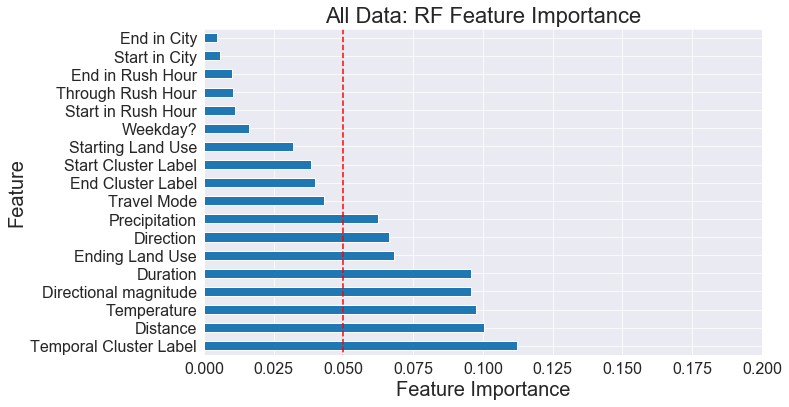

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.5981776354368713


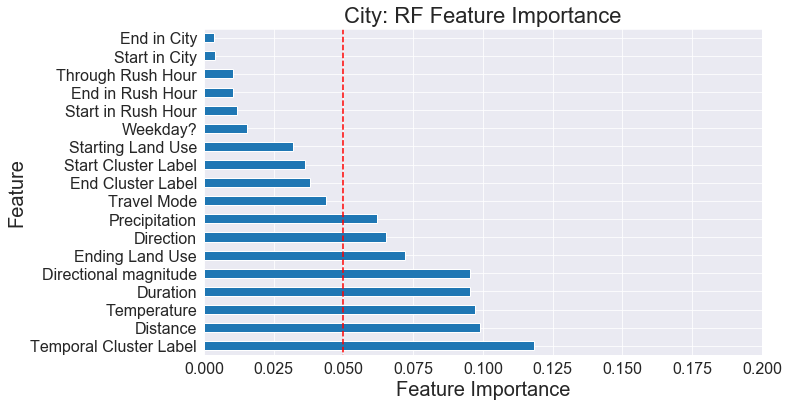

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.47771952817824376


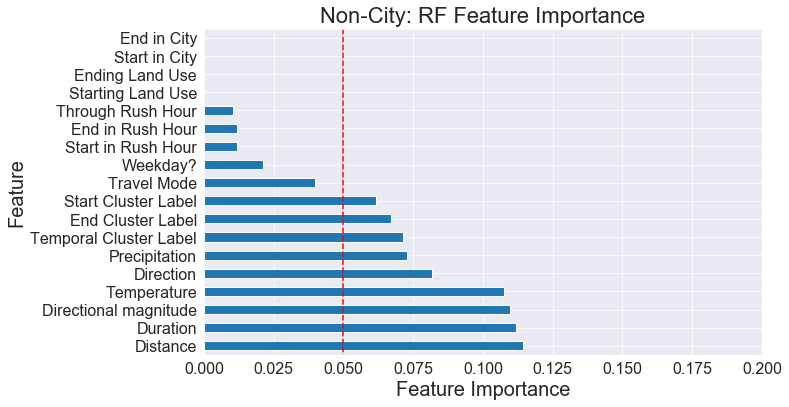

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.6591301735146098


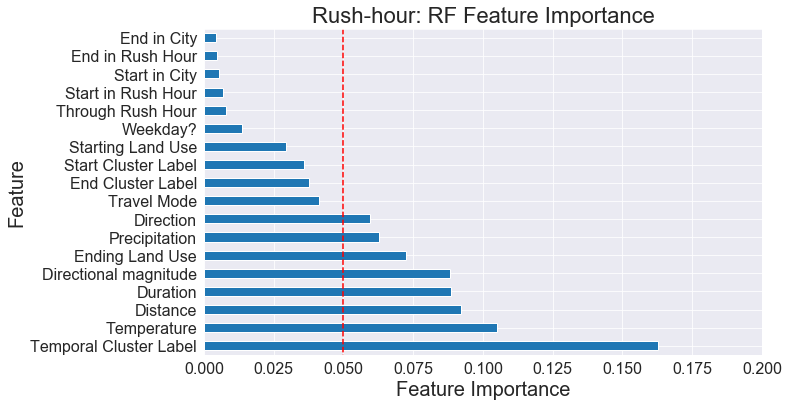

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.5057792332883837


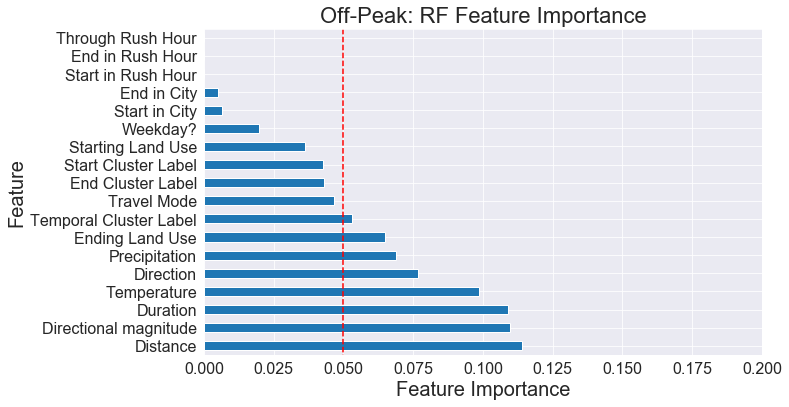

In [719]:
# plot and save
for df, df_name, titles in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"],\
                               ["All Data", "City","Non-City","Rush-hour","Off-Peak"] ):
    clf, feature_list, scores = run_rf(df, norm=True, cv=False)
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    ax = plot_feature_imp(feature_importances, title="{0}: RF Feature Importance".format(titles))
    ax.figure.savefig("figures/rf_feat_imp_{0}.png".format(df_name),bbox_inches='tight')
    plt.show()
#     plt.close()

In [ ]:
### OVERSAMPLED VERSION ###

In [913]:
# cv scores
rf_scores_oversampled = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    clf, feature_list, scores = run_rf(df, norm=True, cv=True, oversample=True)
    rf_scores_oversampled[df_name] = scores

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: [0.90589135 0.90741192 0.90570435 0.91115904 0.90523899]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.91066677 0.90973608 0.91073079 0.91013603 0.91012607]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.84411765 0.84334511 0.84551887 0.85436321 0.85242031]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.92229906 0.9285388  0.92226863 0.92683245 0.92591867]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: [0.89189994 0.8873166  0.88566108 0.89243948 0.89087523]


In [917]:
rf_scores

{'purp_gdf': array([0.5901486 , 0.5848488 , 0.59457493, 0.58580189, 0.58864511]),
 'purp_city': array([0.59573523, 0.59224703, 0.6013551 , 0.59304522, 0.59697677]),
 'purp_noncity': array([0.47106109, 0.43890675, 0.45249597, 0.46029173, 0.44805195]),
 'purp_rush': array([0.6559438 , 0.65107249, 0.65711115, 0.65303479, 0.65598963]),
 'purp_nonrush': array([0.50142248, 0.50343846, 0.48778173, 0.49620313, 0.49560883])}

In [918]:
rf_scores_oversampled

{'purp_gdf': array([0.90589135, 0.90741192, 0.90570435, 0.91115904, 0.90523899]),
 'purp_city': array([0.91066677, 0.90973608, 0.91073079, 0.91013603, 0.91012607]),
 'purp_noncity': array([0.84411765, 0.84334511, 0.84551887, 0.85436321, 0.85242031]),
 'purp_rush': array([0.92229906, 0.9285388 , 0.92226863, 0.92683245, 0.92591867]),
 'purp_nonrush': array([0.89189994, 0.8873166 , 0.88566108, 0.89243948, 0.89087523])}

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.9255963730350409


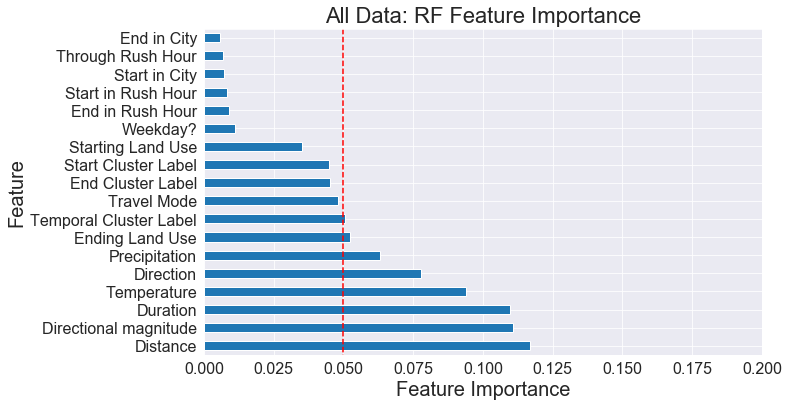

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.9298000720461095


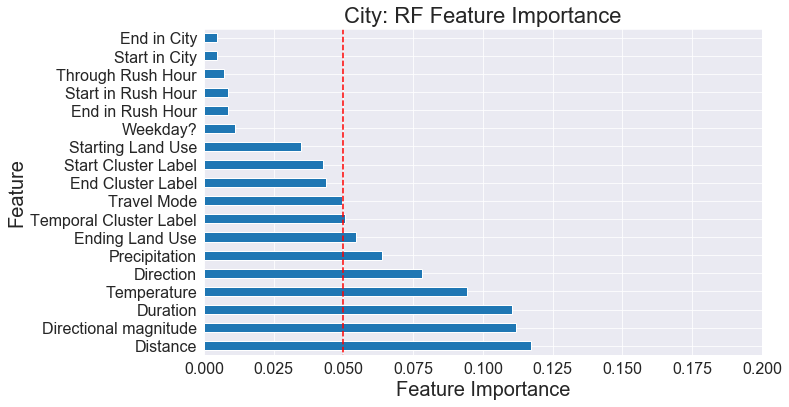

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.873444976076555


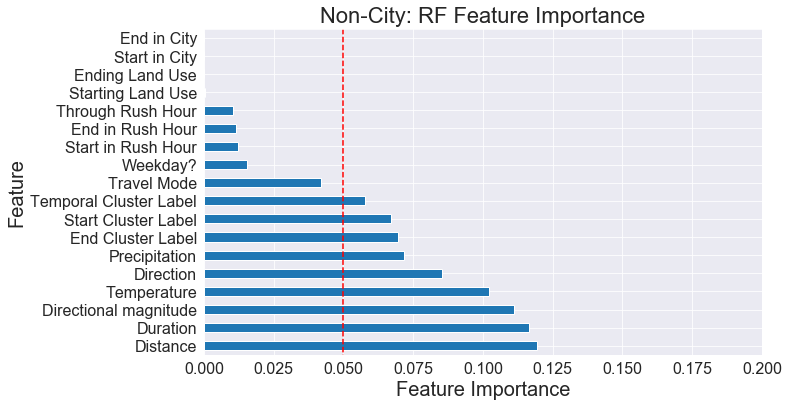

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.9391048573018523


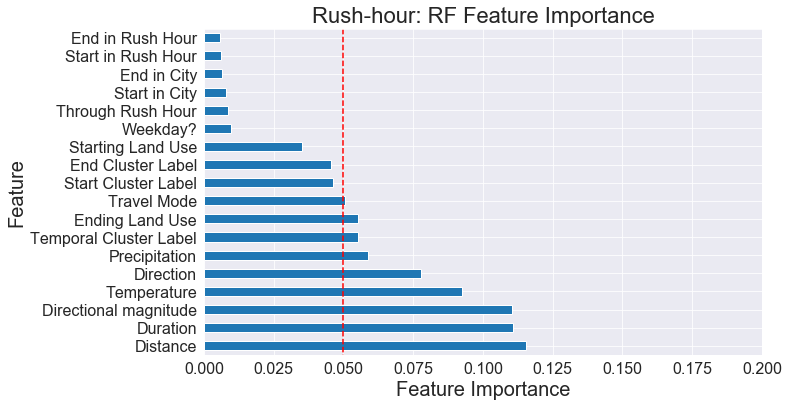

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.9153511159499184


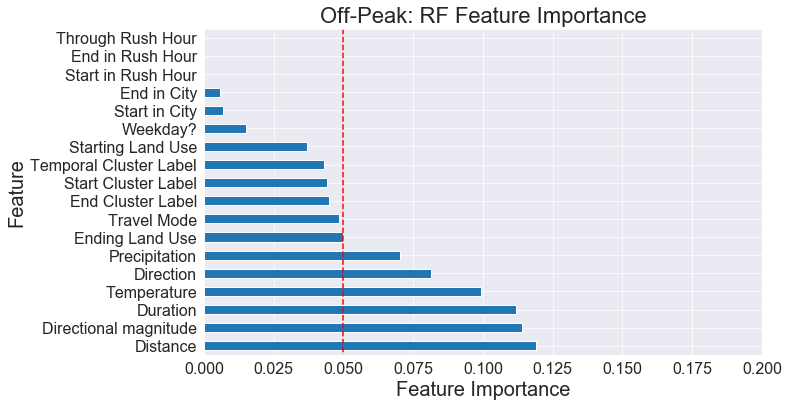

In [916]:
# plot and save
for df, df_name, titles in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"],\
                               ["All Data", "City","Non-City","Rush-hour","Off-Peak"] ):
    clf, feature_list, scores = run_rf(df, norm=True, cv=False, oversample=True)
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    ax = plot_feature_imp(feature_importances, title="{0}: RF Feature Importance".format(titles))
#     ax.figure.savefig("figures/rf_feat_imp_{0}_oversampled.png".format(df_name),bbox_inches='tight')
    plt.show()
#     plt.close()

In [783]:
%%time
## all multi-class results using the same train_test_split 
num_dims = {}
uniq_ids = {}
cv_scores_mcrf = {}
mcrf_preds_dict = {}
cv_scores_svc = {}
svc_preds_dict = {}
cv_scores_nn = {}
nn_preds_dict = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    print(df_name)
    clf, feature_list, _ = run_rf(df, norm=True, cv=False);
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    data = subset_to_imp_features(df, above_005)
    all_inputs, y_codes = encode_inputs(data)
    num_dims[df_name] = all_inputs.shape
    X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
    id_in_order = X_test[::,-1]
    uniq_ids[df_name] = id_in_order
    X_train = X_train[::,:-1]
    X_test = X_test[::,:-1]
    
    y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
    y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclass
    mcrf_scores, mcrf_preds = run_mcrf(all_inputs, y_codes, cv=True, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    cv_scores_mcrf[df_name] = mcrf_scores
    mcrf_preds_dict[df_name] = mcrf_preds
    
    svc_scores, svc_preds = run_svc(X_train, X_test, y_single_train, y_single_test, cv=False)
    cv_scores_svc[df_name] = svc_scores
    svc_preds_dict[df_name] = svc_preds
    
    nn_scores, nn_preds = run_ann(X_train, X_test, y_train, y_test, cv=True)
    cv_scores_nn[df_name] = nn_scores
    nn_preds_dict[df_name] = nn_preds


purp_gdf


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score: 0.5875501160582401


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


purp_city


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.5992151202129099


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


purp_noncity


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.481651376146789


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


purp_rush


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.6601817772102456


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


purp_nonrush


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.5088614910421884


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 50min 15s, sys: 3min 59s, total: 54min 14s
Wall time: 32min 51s


In [ ]:
%%time
### OVERSAMPLED VERSION ####
# 4 hours 5 mins
## all multi-class results using the same train_test_split 
num_dims_oversampled = {}
uniq_ids_oversampled = {}
cv_scores_mcrf_oversampled = {}
mcrf_preds_dict_oversampled = {}
cv_scores_svc_oversampled = {}
svc_preds_dict_oversampled = {}
cv_scores_nn_oversampled = {}
nn_preds_dict_oversampled = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    print(df_name)
    clf, feature_list, _ = run_rf(df, norm=True, cv=False);
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    data = subset_to_imp_features(df, above_005)
    all_inputs, y_codes = encode_inputs(data)
    X_resampled, y_resampled = ros.fit_resample(all_inputs, y_codes)
    num_dims_oversampled[df_name] = all_inputs.shape
#     X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

    id_in_order = X_test[::,-1]
    uniq_ids_oversampled[df_name] = id_in_order
    X_train = X_train[::,:-1]
    X_test = X_test[::,:-1]
    
    y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
    y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclass
    mcrf_scores, single_score, mcrf_preds = run_mcrf(X_resampled, y_resampled, cv=False, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    print("rf", single_score)
    cv_scores_mcrf_oversampled[df_name] = mcrf_scores
    mcrf_preds_dict_oversampled[df_name] = mcrf_preds
    
    svc_scores,single_score, svc_preds = run_svc(X_train, X_test, y_single_train, y_single_test, cv=False)
    print("svc", single_score)
    cv_scores_svc_oversampled[df_name] = svc_scores
    svc_preds_dict_oversampled[df_name] = svc_preds
    
    nn_scores, single_score, nn_preds = run_ann(X_train, X_test, y_train, y_test, cv=False)
    print("nn", single_score)
    cv_scores_nn_oversampled[df_name] = nn_scores
    nn_preds_dict_oversampled[df_name] = nn_preds

    


In [27]:
%%time
### OVERSAMPLED VERSION ####
# 4 hours 5 mins
## all multi-class results using the same train_test_split 
num_dims_oversampled = {}
uniq_ids_oversampled = {}
cv_scores_mcrf_oversampled = {}
mcrf_preds_dict_oversampled = {}
cv_scores_svc_oversampled = {}
svc_preds_dict_oversampled = {}
cv_scores_nn_oversampled = {}
nn_preds_dict_oversampled = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    print(df_name)
    clf, feature_list, _ = run_rf(df, norm=True, cv=False);
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    data = subset_to_imp_features(df, above_005)
    all_inputs, y_codes = encode_inputs(data)
    X_resampled, y_resampled = ros.fit_resample(all_inputs, y_codes)
    num_dims_oversampled[df_name] = X_resampled.shape
#     X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

    id_in_order = X_test[::,-1]
    uniq_ids_oversampled[df_name] = id_in_order
    X_train = X_train[::,:-1]
    X_test = X_test[::,:-1]
    
    y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
    y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclass
    mcrf_scores, single_score, mcrf_preds = run_mcrf(X_resampled, y_resampled, cv=False, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    print("rf", single_score)
    cv_scores_mcrf_oversampled[df_name] = mcrf_scores
    mcrf_preds_dict_oversampled[df_name] = mcrf_preds
    
    svc_scores,single_score, svc_preds = run_svc(X_train, X_test, y_single_train, y_single_test, cv=False)
    print("svc", single_score)
    cv_scores_svc_oversampled[df_name] = svc_scores
    svc_preds_dict_oversampled[df_name] = svc_preds
    
    nn_scores, single_score, nn_preds = run_ann(X_train, X_test, y_train, y_test, cv=False)
    print("nn", single_score)
    cv_scores_nn_oversampled[df_name] = nn_scores
    nn_preds_dict_oversampled[df_name] = nn_preds

    


purp_gdf


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:77: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score: 0.5561825726141079
rf 0.8579370190840988


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

svc 0.18949640125193495
nn 0.10914884241212162
purp_city


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

KeyboardInterrupt: 

In [53]:
%%time
### OVERSAMPLED VERSION ####
# 4 hours 5 mins
## all multi-class results using the same train_test_split 
num_dims_oversampled = {}
uniq_ids_oversampled = {}
cv_scores_mcrf_oversampled = {}
mcrf_preds_dict_oversampled = {}
cv_scores_svc_oversampled = {}
svc_preds_dict_oversampled = {}
cv_scores_nn_oversampled = {}
nn_preds_dict_oversampled = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    print(df_name)
    clf, feature_list, _ = run_rf(df, norm=True, cv=False);
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    data = subset_to_imp_features(df, above_005)
    all_inputs, y_codes = encode_inputs(data)
    X_resampled, y_resampled = ros.fit_resample(all_inputs, y_codes)
    num_dims_oversampled[df_name] = X_resampled.shape
#     X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

    id_in_order = X_test[::,-1]
    uniq_ids_oversampled[df_name] = id_in_order
    X_train = X_train[::,:-1]
    X_test = X_test[::,:-1]
    
    y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
    y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclass
    mcrf_scores, single_score, mcrf_preds = run_mcrf(X_resampled, y_resampled, cv=False, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    print("rf", single_score)
    cv_scores_mcrf_oversampled[df_name] = mcrf_scores
    mcrf_preds_dict_oversampled[df_name] = mcrf_preds
    
    svc_scores,single_score, svc_preds = run_svc(X_train, X_test, y_single_train, y_single_test, cv=False)
    print("svc", single_score)
    cv_scores_svc_oversampled[df_name] = svc_scores
    svc_preds_dict_oversampled[df_name] = svc_preds
    
    nn_scores, single_score, nn_preds = run_ann(X_train, X_test, y_train, y_test, cv=False)
    print("nn", single_score)
    cv_scores_nn_oversampled[df_name] = nn_scores
    nn_preds_dict_oversampled[df_name] = nn_preds

    


In [75]:
rus = RandomUnderSampler(random_state=0)

In [92]:
X_resampled.shape

(250, 23)

In [108]:
%%time
### UNDERSAMPLED VERSION ####
# 30 mins
## all multi-class results using the same train_test_split 
num_dims_undersampled = {}
uniq_ids_undersampled = {}
cv_scores_mcrf_undersampled = {}
mcrf_preds_dict_undersampled = {}
cv_scores_svc_undersampled = {}
svc_preds_dict_undersampled = {}
cv_scores_nn_undersampled = {}
nn_preds_dict_undersampled = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    print(df_name)
    clf, feature_list, _ = run_rf(df, norm=True, cv=False);
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    data = subset_to_imp_features(df, above_005)
    all_inputs, y_codes = encode_inputs(data)
    X_resampled, y_resampled = rus.fit_resample(all_inputs, y_codes)
    print(X_resampled.shape)
    num_dims_undersampled[df_name] = X_resampled.shape
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

    id_in_order = X_test[::,-1]
    uniq_ids_undersampled[df_name] = id_in_order
    X_train = X_train[::,:-1]
    X_test = X_test[::,:-1]
    print("building rf")
    y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
    y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclass
    mcrf_scores, single_score, mcrf_preds = run_mcrf(X_resampled, y_resampled, cv=True, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    print("rf", single_score)
    cv_scores_mcrf_undersampled[df_name] = mcrf_scores
    mcrf_preds_dict_undersampled[df_name] = mcrf_preds
    
    svc_scores,single_score, svc_preds = run_svc(X_train, X_test, y_single_train, y_single_test, cv=True)
    print("svc", single_score)
    cv_scores_svc_undersampled[df_name] = svc_scores
    svc_preds_dict_undersampled[df_name] = svc_preds
    
    nn_scores, single_score, nn_preds = run_ann(X_train, X_test, y_train, y_test, cv=True)
    print("nn", single_score)
    cv_scores_nn_undersampled[df_name] = nn_scores
    nn_preds_dict_undersampled[df_name] = nn_preds

    


purp_gdf


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:77: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score: 0.563536611099388
(8352, 23)
building rf
rf 0.034457743924555674


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

svc 0.10736307580703663
nn 0.04715270221254987
purp_city


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.571293247327349
(7648, 23)
building rf
rf 0.04041204437400951


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

svc 0.11846275752773376
nn 0.04318541996830428
purp_noncity


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.4796854521625164
(704, 23)
building rf
rf 0.017167381974248927
svc 0.0944206008583691


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

nn 0.12875536480686695
purp_rush


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.6461353564185383
(4360, 23)
building rf
rf 0.05142460041695622


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

svc 0.1063238359972203
nn 0.09937456567060458
purp_nonrush


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.4701406280100173
(3992, 23)
building rf
rf 0.019726858877086494


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

svc 0.10698027314112292
nn 0.05918057663125948
CPU times: user 9min 14s, sys: 36.6 s, total: 9min 50s
Wall time: 5min 15s


In [788]:
num_dims

{'purp_gdf': (71801, 18),
 'purp_city': (67177, 18),
 'purp_noncity': (4624, 23),
 'purp_rush': (40342, 18),
 'purp_nonrush': (31459, 18)}

In [113]:
num_dims_oversampled

{'purp_gdf': (214552, 23),
 'purp_city': (201888, 23),
 'purp_noncity': (12664, 23),
 'purp_rush': (114352, 23),
 'purp_nonrush': (100200, 23)}

In [114]:
len(purp_gdf)

71801

In [30]:
cv_scores_mcrf_oversampled


{'purp_gdf': array([0.80997062, 0.80446107, 0.80475833])}

In [31]:
cv_scores_svc_oversampled

{'purp_gdf': array([0.18637418, 0.19030287, 0.18760435])}

In [32]:

cv_scores_nn_oversampled

{'purp_gdf': array([0.1101743 , 0.1101743 , 0.11179564])}

In [109]:
num_dims_undersampled

{'purp_gdf': (8352, 23),
 'purp_city': (7648, 23),
 'purp_noncity': (704, 23),
 'purp_rush': (4360, 23),
 'purp_nonrush': (3992, 23)}

In [110]:
cv_scores_mcrf_undersampled

{'purp_gdf': array([0.04021448, 0.04021448, 0.04289544, 0.04021448, 0.03485255]),
 'purp_city': array([0.03707317, 0.03414634, 0.03219512, 0.03219512, 0.03710938]),
 'purp_noncity': array([0.03157895, 0.05319149, 0.03191489, 0.05319149, 0.0106383 ]),
 'purp_rush': array([0.04957265, 0.04109589, 0.05479452, 0.05993151, 0.05308219]),
 'purp_nonrush': array([0.02990654, 0.01495327, 0.02429907, 0.02242991, 0.02247191])}

In [111]:
cv_scores_svc_undersampled

{'purp_gdf': array([0.13368984, 0.1338091 , 0.13404826, 0.13339302, 0.13351254]),
 'purp_city': array([0.12840467, 0.12865497, 0.12780488, 0.12805474, 0.12818004]),
 'purp_noncity': array([0.14285714, 0.13829787, 0.13829787, 0.13978495, 0.14130435]),
 'purp_rush': array([0.13435374, 0.13481229, 0.13379074, 0.13402062, 0.13402062]),
 'purp_nonrush': array([0.133829  , 0.13407821, 0.13457944, 0.13320826, 0.13370998])}

In [112]:
cv_scores_nn_undersampled

{'purp_gdf': array([0.06434316, 0.06523682, 0.05719392, 0.05987489, 0.07327971]),
 'purp_city': array([0.04585366, 0.05463415, 0.05365854, 0.06634146, 0.06835938]),
 'purp_noncity': array([0.05263158, 0.08510638, 0.18085106, 0.15957447, 0.11702128]),
 'purp_rush': array([0.1025641 , 0.09075342, 0.10958904, 0.09417808, 0.10616438]),
 'purp_nonrush': array([0.05233645, 0.06728972, 0.05794393, 0.06168224, 0.04868914])}

## make dataframe out of predictions


In [796]:
mcrf_preds_dict['purp_gdf'].shape

(23695, 8)

In [789]:
all_preds = np.concatenate((uniq_ids['purp_gdf'].reshape(-1,1),mcrf_preds_dict['purp_gdf'],svc_preds_dict['purp_gdf'].reshape(-1,1), nn_preds_dict['purp_gdf']), axis=1)

In [795]:
all_preds

array([[3.24936e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.30057e+05, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.18473e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.73100e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.20640e+04, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.35500e+03, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [797]:
pd.DataFrame(all_preds, columns=["id","rf1","rf2","rf3","rf4","rf5","rf6","rf7","rf8","svcall","nn1","nn2","nn3","nn4","nn5","nn6","nn7","nn8"]).to_csv("analysis_results/model_class_output_preds.csv", index=False)

In [798]:
model_preds = pd.read_csv("analysis_results/model_class_output_preds.csv")

In [800]:
joined_data_model = gdf.merge(model_preds, left_on='id_trip',right_on='id', how='right')#[["id_trip","rf1","rf2","rf3","rf4","rf5","svcall","nn1","nn2","nn3","nn4","nn5"]]

In [801]:
joined_data_model['starttime'] = joined_data_model['starttime'].astype(str)
joined_data_model['endtime'] = joined_data_model['endtime'].astype(str)
joined_data_model['start_can'] = joined_data_model['start_can'].astype(str)
joined_data_model['start_wgs'] = joined_data_model['start_wgs'].astype(str)
joined_data_model['end_can'] = joined_data_model['end_can'].astype(str)
joined_data_model['end_wgs'] = joined_data_model['end_wgs'].astype(str)

In [808]:
joined_data_model.to_file("analysis_results/joined_model_data.shp")

In [291]:
# gpd.read_file("analysis_results/joined_model_data.shp")

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,rf3,rf4,rf5,svcall,nn1,nn2,nn3,nn4,nn5,geometry
0,358412,3,work,2017-09-18 07:27:38-04:00,2017-09-18 07:40:26-04:00,768,992.314303,211.576183,0.347807,2,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7629026.972989381 1247452.25399864...
1,35763,0,shops,2017-09-18 07:32:54-04:00,2017-09-18 08:04:07-04:00,1873,6832.113937,338.681845,0.002750,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7641918.591122856 1236660.83022967...
2,230363,2,work,2017-09-18 07:33:37-04:00,2017-09-18 08:16:09-04:00,2552,8500.854359,127.802412,0.098128,4,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,(LINESTRING (7625449.252399736 1247376.6710083...
3,143596,7,work,2017-09-18 10:39:19-04:00,2017-09-18 10:55:09-04:00,950,2642.961059,349.675299,0.185333,13,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,(LINESTRING (7630815.520267755 1246190.8794987...
4,313223,3,work,2017-09-18 11:29:35-04:00,2017-09-18 11:31:54-04:00,139,226.672022,66.405847,0.252944,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (7631532.876323251 1245163.99977121...
5,353958,0,work,2017-09-18 11:45:48-04:00,2017-09-18 12:10:22-04:00,1474,8685.133631,308.020841,0.073248,7,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7628061.786595868 1240569.55374326...
6,44664,4,work,2017-09-18 11:57:12-04:00,2017-09-18 12:17:29-04:00,1217,3228.128354,155.607434,0.189776,8,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7626422.447991624 1246687.45536286...
7,474247,0,work,2017-09-18 12:57:40-04:00,2017-09-18 13:21:00-04:00,1400,445.897686,91.763257,0.320339,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,LINESTRING (7631172.703754629 1254786.97950467...
8,443357,3,shops,2017-09-18 13:04:11-04:00,2017-09-18 13:22:58-04:00,1127,650.601955,19.992785,0.164362,6,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,LINESTRING (7631364.037662272 1244778.99428346...
9,135984,7,returning_home,2017-09-18 13:15:17-04:00,2017-09-18 13:29:09-04:00,832,1979.418259,161.115251,0.214882,8,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,(LINESTRING (7629893.274594538 1247934.1841953...


In [277]:
model_preds

,id,rf1,rf2,rf3,rf4,rf5,svcall,nn1,nn2,nn3,nn4,nn5
0,324936.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,430057.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
2,218473.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,377109.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,18555.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,248398.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,338042.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
7,389933.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0
8,92804.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,233879.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [201]:
X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)

In [202]:
X_train

array([[4.08510313e-01, 6.00000000e-01, 1.83113851e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.68064304e-01, 6.00000000e-01, 1.83113851e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.03085037e-01, 4.00000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.66872514e-01, 8.00000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.07411911e-01, 1.00000000e+00, 4.57784628e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.04625088e-01, 2.00000000e-01, 3.14498039e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [191]:
model_preds

,rf1,rf2,rf3,rf4,rf5,svcall,nn1,nn2,nn3,nn4,nn5
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## evaluate predictions

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Below is the working out of the classifiers

## Normalise

In [349]:
gdf.purpose.unique()

array(['pick_up_a_person', 'work', 'shops', 'returning_home', 'health',
       'leisure', 'education', 'cafe'], dtype=object)

In [350]:
gdf.purpose.unique()[:]

array(['pick_up_a_person', 'work', 'shops', 'returning_home', 'health',
       'leisure', 'education', 'cafe'], dtype=object)

In [351]:
data = gdf.copy()
weeks = {"first":["2017-09-18","2017-09-24"],
        "second":["2017-09-25","2017-10-1"],
        "third":["2017-10-02","2017-10-08"],
        "fourth":["2017-10-09","2017-10-15"],
        "fifth":["2017-10-16","2017-10-24"]}
week_date = weeks[list(weeks.keys())[0]][1]

train, test = data.set_index('starttime')[:week_date], data.set_index('starttime')[week_date:]

In [352]:
# purpose_factorise = pd.factorize(data['purpose'])
mode_factorise = pd.factorize(data['mode'])

# gdf['purpose'] = pd.factorize(data['purpose'])[0]
data['mode'] = pd.factorize(data['mode'])[0]
data['carddir'] = pd.factorize(data['carddir'])[0]
# gdf['startclust'] = pd.factorize(gdf['startclust'])[0]
# gdf['endclust'] = pd.factorize(gdf['endclust'])[0]

In [353]:
data.columns

Index(['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush', 'lda_word', 'temporal_c', 'precip', 'temperatur',
       'land_use', 'start_wgs', 'end_wgs', 'start_can', 'end_can', 'geometry',
       'log_dur', 'log_dist', 'purpose_labels', 'land_use_start',
       'land_use_end', 'trip_durations', 'startx', 'starty', 'endx', 'endy',
       'startclust', 'endclust'],
      dtype='object')

In [354]:
X = data[["mode","log_dur","log_dist","magnitude","carddir","start_down",\
          "end_downto","weekday", "temporal_c","precip","temperatur",\
        "startrush","endrush","thrurush","startclust","endclust"]]
y = data[["purpose_labels"]]

In [355]:
X.head()

,mode,log_dur,log_dist,magnitude,carddir,start_down,end_downto,weekday,temporal_c,precip,temperatur,startrush,endrush,thrurush,startclust,endclust
0,0,6.760415,9.204013,0.304086,0,1,1,1,1,0.0,18.353766,1,1,1,2,10
1,0,7.957527,9.634612,0.232414,1,0,0,1,2,0.0,17.317364,1,1,1,8,8
2,1,8.014336,8.956578,0.121941,1,1,1,1,2,0.0,17.317364,1,1,1,0,1
3,2,7.997327,8.948264,0.048575,1,1,1,1,2,0.0,17.317364,1,1,1,5,5
4,3,6.645091,6.901047,0.347807,2,1,1,1,2,0.0,17.440628,1,1,1,0,0


In [356]:
y.head()

,purpose_labels
0,4
1,5
2,5
3,5
4,5


In [357]:
# enc = OneHotEncoder(categories='auto')
X.weekday = X.weekday.astype(int)

X = X / np.amax(X, axis=0)
# norm_y = y / np.amax(y, axis=0)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [358]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [359]:
X.values

array([[0.        , 0.72838638, 0.79970196, ..., 1.        , 0.18181818,
        0.90909091],
       [0.        , 0.85736673, 0.83711508, ..., 1.        , 0.72727273,
        0.72727273],
       [0.01538462, 0.86348742, 0.77820331, ..., 1.        , 0.        ,
        0.09090909],
       ...,
       [0.06153846, 0.76577432, 0.75452257, ..., 0.        , 0.        ,
        0.09090909],
       [0.03076923, 0.66222307, 0.65904255, ..., 0.        , 0.90909091,
        0.        ],
       [0.03076923, 0.67401237, 0.66413786, ..., 0.        , 0.90909091,
        0.90909091]])

In [360]:
X_train.head()

,mode,log_dur,log_dist,magnitude,carddir,start_down,end_downto,weekday,temporal_c,precip,temperatur,startrush,endrush,thrurush,startclust,endclust
67390,0.030769,0.673390,0.558610,0.523046,0.600000,1.0,1.0,0.0,0.8,0.070285,0.582879,1.0,0.0,0.0,0.181818,0.181818
13322,0.000000,0.690473,0.758939,0.589122,0.733333,1.0,1.0,1.0,0.2,0.012299,0.835730,0.0,0.0,0.0,0.000000,0.000000
57241,0.046154,0.490648,0.381061,0.751390,0.933333,1.0,1.0,1.0,0.4,0.000122,0.416091,1.0,1.0,1.0,0.000000,0.000000
4427,0.061538,0.802943,0.748732,0.397205,0.600000,1.0,1.0,0.0,0.8,0.000015,0.842669,1.0,1.0,1.0,0.000000,0.000000
40795,0.015385,0.906840,0.756738,0.505869,0.866667,1.0,1.0,1.0,0.8,0.192849,0.499718,0.0,0.0,0.0,0.090909,0.181818


In [361]:
y.head()

,purpose_labels
0,4
1,5
2,5
3,5
4,5


## Random forest for Feature Importance

In [43]:
feature_list = list(X.columns)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
clf.fit(X_train, y_train)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [687]:
clf.score(X_test,y_test)

0.8007174509390167

In [688]:
clf.feature_importances_

array([0.26168969, 0.14567933, 0.14873093, 0.14497527, 0.14371244,
       0.07800756, 0.07720478])

In [77]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

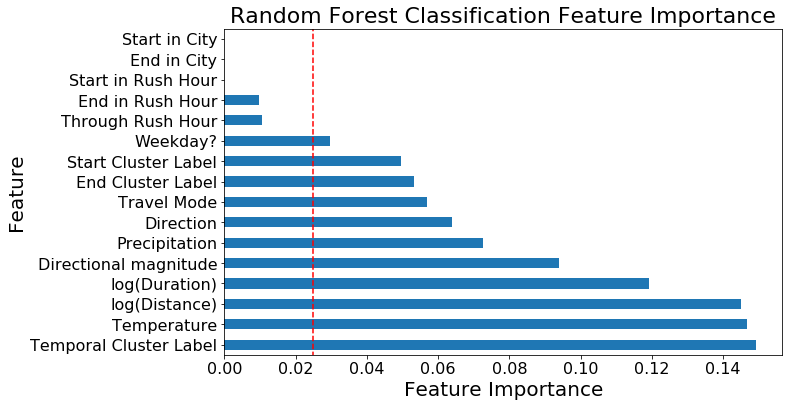

In [78]:
feat_imps_current = ["Temporal Cluster Label","Temperature",'log(Distance)', 'log(Duration)',\
                     'Directional magnitude', "Precipitation",'Direction', 'Travel Mode', 'End Cluster Label',\
                     'Start Cluster Label', 'Weekday?','Through Rush Hour', 'End in Rush Hour',\
                     'Start in Rush Hour', 'End in City', 'Start in City']
fig, ax = plt.subplots(1, figsize=(10,6))
feat_imp = pd.DataFrame(feature_importances, columns=['importance', 'feature'])
feat_imp.plot(kind='barh', ax=ax, legend=False)
# ax.set_yticklabels(list(feat_imp.importance.values), size=16);
ax.set_yticklabels(feat_imps_current, size=16);
plt.xticks(size=16);
plt.xlabel("Feature Importance", size=20)
plt.ylabel("Feature", size=20)
plt.title("Random Forest Classification Feature Importance", size=22)
plt.vlines(0.025,-10,50, color='r', linestyles='--')
# plt.savefig("figures/rf_classification_imp_2fi.png", bbox_inches='tight')

In [676]:
feature_importances[:7]

[('temporal_c', 0.22405),
 ('temperatur', 0.11788),
 ('log_dist', 0.10879),
 ('log_dur', 0.10442),
 ('magnitude', 0.10411),
 ('precip', 0.06783),
 ('carddir', 0.06369)]

## re-subset

In [285]:
X = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip","carddir"]]
y = data[["purpose_labels"]]

In [286]:
data = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip","carddir", "purpose_labels"]]
X = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip","carddir"]]
y = data[["purpose_labels"]]

## One Hot Encoding

In [362]:
enc = OneHotEncoder(handle_unknown='ignore')

# mode_codes = enc.fit_transform(data['mode'].values.reshape(-1, 1)).toarray()
carddir_codes = enc.fit_transform(data['carddir'].values.reshape(-1, 1)).toarray()
# stcl_codes = enc.fit_transform(data['startclust'].values.reshape(-1, 1)).toarray()
# encl_codes = enc.fit_transform(data['endclust'].values.reshape(-1, 1)).toarray()
# sthr_codes = enc.fit_transform(data['starthour'].values.reshape(-1, 1)).toarray()
# enhr_codes = enc.fit_transform(data['endhour'].values.reshape(-1, 1)).toarray()
y_codes = enc.fit_transform(data['purpose_labels'].values.reshape(-1, 1)).toarray()

In [363]:
data['purpose_labels'].value_counts()

1    47464
5    18950
2     2769
4     1574
3     1044
Name: purpose_labels, dtype: int64

In [364]:
non_codes = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip"]] # without carddir
# non_codes['weekday'] = non_codes['weekday'].astype(int)
feature_list = list(non_codes)
non_codes = non_codes.values
non_codes = non_codes / np.amax(non_codes, axis=0)

In [365]:
all_input = np.concatenate((non_codes,carddir_codes), axis=1) # mode_codes stcl_codes encl_codes sthr_codes enhr_codes

In [375]:
all_input.shape

(71801, 22)

In [367]:
y_codes.shape

(71801, 5)

In [368]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(all_input, y_codes, test_size=0.33, random_state=42)

## Multi-Class Random Forest:

In [836]:
%%time 
# Random forest classifier

# clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
multi_target_forest = MultiOutputClassifier(clf, n_jobs=-1)

CPU times: user 46 µs, sys: 1e+03 ns, total: 47 µs
Wall time: 53.2 µs


In [837]:
print(X_train.shape)
print(y_train.shape)

(48106, 22)
(48106, 5)


In [838]:
multi_target_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=10,
                                                       n_jobs=None,
                  

In [839]:
multi_target_forest.score(X_test, y_test)

0.7372863473306605

In [842]:
res = pd.DataFrame(multi_target_forest.predict(X_test), columns=np.arange(1,6))

In [843]:
res.head()

,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [844]:
# predictions of 1, predictions of 0 and predictions of 2
res.sum(axis=1).value_counts()

1.0    21149
0.0     2369
2.0      177
dtype: int64

In [845]:
res.sum()

1    16576.0
2       13.0
3        0.0
4        1.0
5     4913.0
dtype: float64

In [846]:
def check_accuracy(pred, original):
    vals = []
    for i in range(len(pred)):
        if sum(pred[i]) == 1:
            if np.where(original[i])[0][0] == np.where(pred[i])[0][0]:
                vals.append(True)
            else:
                vals.append(False)
            
            
        elif sum(pred[i]) == 0:
            vals.append("No pred")
        else:
            vals.append(False)
    return vals

In [847]:
pred_res = pd.DataFrame(y_test, columns=np.arange(1,6))
pred_res['res'] = check_accuracy(multi_target_forest.predict(X_test), y_test)

In [848]:
pred_res.head()

,1,2,3,4,5,res
0,1.0,0.0,0.0,0.0,0.0,True
1,0.0,0.0,1.0,0.0,0.0,False
2,1.0,0.0,0.0,0.0,0.0,True
3,1.0,0.0,0.0,0.0,0.0,True
4,1.0,0.0,0.0,0.0,0.0,True


In [849]:
y_test

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [850]:
no_vals

{1: 1092, 2: 177, 3: 56, 4: 51, 5: 993}

In [857]:
wrong_vals = {}
no_vals = {}
total_vals = {}
for col in pred_res.columns[:-1]:
    wrong_vals[col] = pred_res.loc[pred_res[col] == 1.0].res.value_counts()
    wrong_vals[col] = len(pred_res.loc[(pred_res[col] == 1.0) &(pred_res.res == False)])
    no_vals[col] = pred_res.loc[pred_res[col] == 1.0].res.value_counts()['No pred']
    total_vals[col] = pred_res[col].sum()
    print(col,":\n", pred_res.loc[pred_res[col] == 1.0].res.value_counts(), "\n")

1 :
 True       13886
No pred     1092
False        683
Name: res, dtype: int64 

2 :
 False      777
No pred    177
True         1
Name: res, dtype: int64 

3 :
 False      266
No pred     56
Name: res, dtype: int64 

4 :
 False      458
No pred     51
True         1
Name: res, dtype: int64 

5 :
 True       3582
False      1672
No pred     993
Name: res, dtype: int64 



In [858]:
wrong_vals,total_vals, no_vals

({1: 683, 2: 777, 3: 266, 4: 458, 5: 1672},
 {1: 15661.0, 2: 955.0, 3: 322.0, 4: 510.0, 5: 6247.0},
 {1: 1092, 2: 177, 3: 56, 4: 51, 5: 993})

In [859]:
# purpose_counts = gdf.purpose_labels.value_counts().to_dict() 

In [860]:
correct_perc = {}
for col in pred_res.columns[:-1]:
    correct_perc[str(col)] = ((total_vals[col] - wrong_vals[col] - no_vals[col]) / (total_vals[col] - no_vals[col]))*100

In [861]:
correct_perc

{'1': 95.31196375866567,
 '2': 0.12853470437017994,
 '3': 0.0,
 '4': 0.2178649237472767,
 '5': 68.1766273315569}

## Support Vector Classification/Regression?

In [370]:
# y_factorised = purpose_factorise[0]
y_svc = y.values
X_train, X_test, y_train, y_test = train_test_split(all_input, y_svc, test_size=0.33, random_state=42)

In [371]:
%%time
clf = svm.SVC(gamma='scale', decision_function_shape='ova')
clf.fit(X_train, y_train)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [880]:
clf.decision_function

<bound method BaseSVC.decision_function of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>

In [881]:
clf.score(X_test, y_test)

0.7471196454948301

In [882]:
svm_preds = clf.predict(X_test)  
len(svm_preds)

23695

In [893]:
pd.DataFrame(y_test, svm_preds.reshape(-1,1))

,0
"(1,)",1
"(5,)",3
"(1,)",1
"(1,)",1
"(1,)",1
"(1,)",1
"(5,)",5
"(5,)",5
"(1,)",1
"(1,)",1


In [888]:
svm_pred_df = pd.DataFrame([y_test, svm_preds]).T
svm_pred_df.columns = ['actual', 'svm_preds']

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [884]:
svm_pred_df.actual.value_counts()

[[1], [3], [1], [1], [1], [1], [5], [5], [1], [1], [1], [1], [2], [4], [1], [1], [1], [5], [5], [1], [5], [5], [5], [1], [1], [5], [2], [1], [5], [5], [5], [5], [1], [5], [1], [5], [5], [5], [5], [5], [1], [5], [1], [5], [5], [1], [5], [1], [5], [1], [1], [1], [1], [1], [1], [5], [1], [5], [1], [1], [5], [1], [1], [1], [1], [5], [1], [1], [1], [1], [1], [5], [1], [1], [1], [5], [1], [5], [1], [1], [5], [5], [1], [1], [1], [5], [1], [5], [1], [5], [1], [1], [1], [1], [1], [5], [1], [5], [5], [1], ...]    1
Name: actual, dtype: int64

In [885]:
svm_pred_df.svm_preds.value_counts()

[1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 5, 5, 1, 5, 1, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, ...]    1
Name: svm_preds, dtype: int64

In [886]:
svm_pred_df.head()

,actual,svm_preds
0,"[[1], [3], [1], [1], [1], [1], [5], [5], [1], ...","[1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 5, 1, 1, ..."


In [78]:
svm_pred_df.loc[svm_pred_df.actual == svm_pred_df.svm_preds]['actual'].value_counts()

3    7745
1    5192
2     521
5     190
Name: actual, dtype: int64

In [ ]:
svm_pred_df.loc[svm_pred_df.actual == svm_pred_df.svm_preds]['actual'].value_counts()

## Grid-Search

In [379]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.1, 1, 10]
    gammas = [0.01, 0.1, 1]
    decision_function_shapes = ['ova','ovo']
    param_grid = {'C': Cs, 'gamma' : gammas, "decision_function_shape":decision_function_shapes}
    
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [296]:
clf, feature_list, _ = run_rf(purp_gdf, norm=False, cv=False);
feature_importances, above_005 = calc_feature_imp(clf, feature_list);
data = subset_to_imp_features(df, above_005)
all_inputs, y_codes = encode_inputs(data)
y_single = np.array([np.where(val)[0]+1 for val in y_codes]) # for svc and nn which dont do multiclass

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score: 0.8114792150242667


In [380]:
%%time
best_params = svc_param_selection(all_input, y_svc, 3)
best_params

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

CPU times: user 15min 1s, sys: 17.7 s, total: 15min 19s
Wall time: 15min 53s


{'C': 0.1, 'decision_function_shape': 'ova', 'gamma': 0.01}

In [300]:
best_params

{'C': 0.1, 'gamma': 0.01}

0.1

In [320]:
parameters = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500],\
              'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':[(50,50,50), (5,10,5), (100,)]}
clf_grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

In [376]:
%%time
clf_grid.fit(all_inputs, y_codes)

NameError: name 'clf_grid' is not defined

In [323]:
clf_grid.best_params_

{'alpha': 0.01,
 'hidden_layer_sizes': (50, 50, 50),
 'max_iter': 500,
 'solver': 'lbfgs'}

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,50), (50,)],
    'activation': ['tanh'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [1e-5, 0.0001, 0.05],
}
# MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [312]:
%%time
mlp = MLPClassifier(max_iter=100)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)

CPU times: user 7.77 s, sys: 720 ms, total: 8.49 s
Wall time: 4min 6s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=100,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...one, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh'], 'alpha': [1e-05, 0.0

In [313]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'adam'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'lbfgs'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'adam'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'lbfgs'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 

In [ ]:
y_true, y_pred = DEAP_y_test , clf.predict(DEAP_x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

## ANN

In [97]:
import numpy as np

dims_of_x = len(all_inputs[0])

class NeuralNetwork():
    
    def __init__(self, dims_of_x):
        # seeding for random number generation
        np.random.seed(1)
        
        #converting weights to a 4 by 1 matrix with values from -1 to 1 and mean of 0
        self.synaptic_weights = 2 * np.random.random((dims_of_x, 1)) - 1

    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)

    def train(self, training_inputs, training_outputs, training_iterations):
        
        #training the model to make accurate predictions while adjusting weights continually
        for iteration in range(training_iterations):
            #siphon the training data via  the neuron
            output = self.think(training_inputs)

            #computing error rate for back-propagation
            error = training_outputs - output
            
            #performing weight adjustments
            adjustments = np.dot(training_inputs.T, error * self.sigmoid_derivative(output))

            self.synaptic_weights += adjustments

    def think(self, inputs):
        #passing the inputs via the neuron to get output   
        #converting values to floats
        
        inputs = inputs.astype(float)
        output = self.sigmoid(np.dot(inputs, self.synaptic_weights))
        return output

In [98]:
X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclas

array([0.78268551, 0.6469182 , 0.79711049, 0.79856564, 0.80334685])

In [99]:
%%time
#initializing the neuron class
neural_network = NeuralNetwork(dims_of_x=len(all_inputs[0]))

print("Beginning Randomly Generated Weights: ")
print(neural_network.synaptic_weights)

#training data consisting of 4 examples--3 input values and 1 output
training_inputs = X_train

training_outputs = y_single_train

#training taking place
neural_network.train(training_inputs, training_outputs, 10000)

print("Ending Weights After Training: ")
print(neural_network.synaptic_weights)

Beginning Randomly Generated Weights: 
[[-0.16595599]
 [ 0.44064899]
 [-0.99977125]
 [-0.39533485]
 [-0.70648822]
 [-0.81532281]
 [-0.62747958]
 [-0.30887855]
 [-0.20646505]
 [ 0.07763347]
 [-0.16161097]
 [ 0.370439  ]
 [-0.5910955 ]
 [ 0.75623487]
 [-0.94522481]
 [ 0.34093502]
 [-0.1653904 ]
 [ 0.11737966]
 [-0.71922612]
 [-0.60379702]
 [ 0.60148914]
 [ 0.93652315]]
Ending Weights After Training: 
[[ 7384.85666521]
 [ 8327.82968914]
 [  525.94367917]
 [ 7552.32498236]
 [11817.40687665]
 [10861.58048211]
 [  549.36033273]
 [ 1099.5872206 ]
 [ 1637.14259492]
 [  777.21204784]
 [ 1095.43110865]
 [  942.16681436]
 [ 1024.39671005]
 [  996.60291997]
 [  585.37636584]
 [  877.86798257]
 [  929.31060692]
 [  959.30870873]
 [  576.94850629]
 [  660.79817919]
 [ 1458.51753601]
 [ 1274.03070634]]
CPU times: user 3min 17s, sys: 25.5 s, total: 3min 43s
Wall time: 2min 6s


In [104]:
all_inputs

array([[0.60817148, 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.46482825, 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24388107, 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.47746443, 0.2       , 0.00245678, ..., 0.        , 0.        ,
        0.        ],
       [0.99960312, 0.2       , 0.00245678, ..., 0.        , 0.        ,
        0.        ],
       [0.67953078, 0.2       , 0.00245678, ..., 0.        , 0.        ,
        0.        ]])

In [105]:
import collections

In [110]:
neural_network.think(X_test)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
# test_data["round_preds"] = test_data.preds.apply(lambda pred: round(pred))

## over sampling

In [811]:
ros

RandomOverSampler(random_state=0, ratio=None, return_indices=False,
                  sampling_strategy='auto')

In [813]:
clf, feature_list, _ = run_rf(purp_city, norm=True, cv=False);
feature_importances, above_005 = calc_feature_imp(clf, feature_list);
data = subset_to_imp_features(data, above_005)
all_inputs, y_codes = encode_inputs(data)
X_resampled, y_resampled = ros.fit_resample(all_inputs, y_codes)
# X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)
id_in_order = X_test[::,-1]
uniq_ids[df_name] = id_in_order
X_train = X_train[::,:-1]
X_test = X_test[::,:-1]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Score: 0.5977716631332041


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [817]:
y_codes

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [821]:
X_resampled, y_resampled = ros.fit_resample(all_inputs, y_codes)

In [824]:
len(all_inputs)

31459

In [825]:
len(X_resampled)

100200

In [828]:
len(y_codes)

31459

In [829]:
len(y_resampled)

100200

In [116]:
y_resampled

array([0, 1, 1, ..., 9, 9, 9])

In [831]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

In [832]:
%%time
# clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 1min 41s, sys: 3.36 s, total: 1min 45s
Wall time: 31.2 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [833]:
the_preds = clf.predict(X_test)  

In [834]:
clf.score(X_test, y_test)

0.8394423274662796